In [1]:
#rdkit関連のimport
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools

#その他のimport
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re


#SDFファイルの読み込み
mol_list  = Chem.SDMolSupplier("../../ForMolPredict/SDF_files/SOL/SOL_AllMOL.sdf",removeHs=False) 
mol_num = len(mol_list)
print("there are {} molecules".format(mol_num))

there are 1214 molecules


In [2]:
#データの抽出
#(A) lowを０それ以外を１とする
SOL_class_list = [0 if mol.GetProp('SOL_class')=='(A) low' else 1 for mol in mol_list]
mol_props = ['Volume', 'Energy', 'HOMO', 'LUMO', 'HLgap', 'Mcharge_ave', 'Mcharge_var', 'Lcharge_ave', 'Lcharge_var', 'dipole', 'Atom_num', 'Mass', 'Density']
maccskeys = []
calc_list = []
for mol in mol_list:
    maccskey = [float(x) for x in AllChem.GetMACCSKeysFingerprint(mol)]
    maccskeys.append(maccskey)
    mol_data = [mol.GetDoubleProp(prop) for prop in mol_props]
    calc_list.append(mol_data)
maccs_df = pd.DataFrame(maccskeys)
Calc_df = pd.DataFrame(calc_list, columns=mol_props)
FC_df = pd.concat([Calc_df, maccs_df], axis=1 )

In [3]:
#データの規格化
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features

resc_list = []
for prop_name, prop_data in Calc_df.iteritems():
    resc_list.append(rescaling(prop_data))
rescCalc_df = pd.DataFrame(resc_list, index=mol_props)
rescCalc_df = rescCalc_df.T
rescFC_df = pd.concat([rescCalc_df, maccs_df], axis=1 )

In [4]:
print('number of Fingerprint:',len(maccs_df.columns))
print('number of Calclation Data:', len(Calc_df.columns))
print('number of All Data:', len(FC_df.columns))
print('number of Rescaled Calclation Data:', len(rescCalc_df.columns))
print('number of Rescaled All Data:', len(rescFC_df.columns))

number of Fingerprint: 167
number of Calclation Data: 13
number of All Data: 180
number of Rescaled Calclation Data: 13
number of Rescaled All Data: 180


In [5]:
#activityのカウント
print('number of 0.0: ',SOL_class_list.count(0))
print('number of 1.0: ',SOL_class_list.count(1))

number of 0.0:  484
number of 1.0:  730


In [8]:
#無制限の決定木
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(maccs_df, SOL_class_list, random_state= 0)
xcalc_train, xcalc_test, ycalc_train, ycalc_test = train_test_split(Calc_df, SOL_class_list, random_state= 0)
xFC_train, xFC_test, yFC_train, yFC_test = train_test_split(FC_df, SOL_class_list, random_state= 0)
xrcalc_train, xrcalc_test, yrcalc_train, yrcalc_test = train_test_split(rescCalc_df, SOL_class_list, random_state= 0)
xrFC_train, xrFC_test, yrFC_train, yrFC_test = train_test_split(rescFC_df, SOL_class_list, random_state= 0)

tree = DecisionTreeClassifier(random_state= 0)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('=======Only Rdkit Finger Print========')
print('accuracy on train set: {:.3f}'.format(tree.score(x_train, y_train)))
print('accuracy on test set: {:.3f}'.format(tree.score(x_test, y_test)))

calc_tree = DecisionTreeClassifier(random_state= 0)
calc_tree.fit(xcalc_train, ycalc_train)
ycalc_pred = calc_tree.predict(xcalc_test)
print('=======Only Calculation Results========')
print('accuracy on train set: {:.3f}'.format(calc_tree.score(xcalc_train, ycalc_train)))
print('accuracy on test set: {:.3f}'.format(calc_tree.score(xcalc_test, ycalc_test)))

FC_tree = DecisionTreeClassifier(random_state= 0)
FC_tree.fit(xFC_train, yFC_train)
yFC_pred = FC_tree.predict(xFC_test)
print('=======Calculation Results + Rdkit Finger Print========')
print('accuracy on train set: {:.3f}'.format(FC_tree.score(xFC_train, yFC_train)))
print('accuracy on test set: {:.3f}'.format(FC_tree.score(xFC_test, yFC_test)))

rcalc_tree = DecisionTreeClassifier(random_state= 0)
rcalc_tree.fit(xrcalc_train, yrcalc_train)
yrcalc_pred = rcalc_tree.predict(xrcalc_test)
print('=======Only Rescaled Calculation Results========')
print('accuracy on train set: {:.3f}'.format(rcalc_tree.score(xrcalc_train, yrcalc_train)))
print('accuracy on test set: {:.3f}'.format(rcalc_tree.score(xrcalc_test, yrcalc_test)))

rFC_tree = DecisionTreeClassifier(random_state= 0)
rFC_tree.fit(xrFC_train, yrFC_train)
yrFC_pred = rFC_tree.predict(xrFC_test)
print('=======Rescaled Calculation Results + Rdkit Finger Print========')
print('accuracy on train set: {:.3f}'.format(rFC_tree.score(xrFC_train, yrFC_train)))
print('accuracy on test set: {:.3f}'.format(rFC_tree.score(xrFC_test, yrFC_test)))

=======Only Rdkit Finger Print========
accuracy on train set: 0.985
accuracy on test set: 0.839
=======Only Calculation Results========
accuracy on train set: 1.000
accuracy on test set: 0.836
=======Calculation Results + Rdkit Finger Print========
accuracy on train set: 1.000
accuracy on test set: 0.845
=======Only Rescaled Calculation Results========
accuracy on train set: 1.000
accuracy on test set: 0.849
=======Rescaled Calculation Results + Rdkit Finger Print========
accuracy on train set: 1.000
accuracy on test set: 0.845


In [11]:
def evaluation(y_test, y_pred):
    from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
    import seaborn as sns
    matrix_fp = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix_fp, square=True, annot=True, cbar=False, fmt='d', cmap='GnBu')
    print('Accuacy(正解率)', accuracy_score(y_test, y_pred))
    print('Precision(適合率)', precision_score(y_test, y_pred))
    print('Recall(再現率)', recall_score(y_test, y_pred))

=======Only Rdkit Finger Print========
Accuacy(正解率) 0.8388157894736842
Precision(適合率) 0.8959537572254336
Recall(再現率) 0.8333333333333334


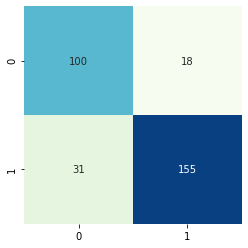

In [12]:
print('=======Only Rdkit Finger Print========')
evaluation(y_test, y_pred)

=======Only Calculation Results========
Accuacy(正解率) 0.8355263157894737
Precision(適合率) 0.8655913978494624
Recall(再現率) 0.8655913978494624


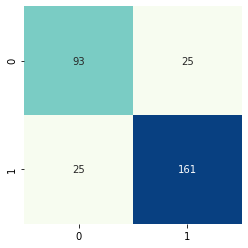

In [13]:
print('=======Only Calculation Results========')
evaluation(ycalc_test, ycalc_pred)

=======Calculation Results + Rdkit Finger Print========
Accuacy(正解率) 0.8453947368421053
Precision(適合率) 0.8756756756756757
Recall(再現率) 0.8709677419354839


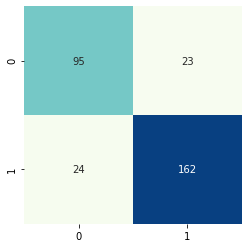

In [14]:
print('=======Calculation Results + Rdkit Finger Print========')
evaluation(yFC_test, yFC_pred)

=======Only Rescaled Calculation Results========
Accuacy(正解率) 0.8486842105263158
Precision(適合率) 0.8888888888888888
Recall(再現率) 0.8602150537634409


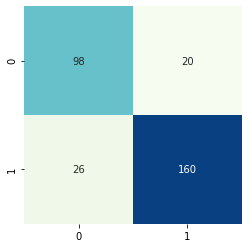

In [15]:
print('=======Only Rescaled Calculation Results========')
evaluation(yrcalc_test, yrcalc_pred)

=======Rescaled Calculation Results + Rdkit Finger Print========
Accuacy(正解率) 0.8453947368421053
Precision(適合率) 0.8797814207650273
Recall(再現率) 0.8655913978494624


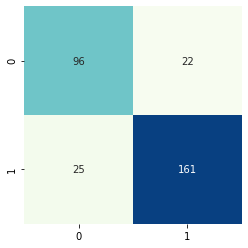

In [16]:
print('=======Rescaled Calculation Results + Rdkit Finger Print========')
evaluation(yrFC_test, yrFC_pred)

In [17]:
# Feature Importance
fti = tree.feature_importances_  
fti2 = calc_tree.feature_importances_   
fti3 = FC_tree.feature_importances_  
fti4 = rcalc_tree.feature_importances_
fti5 = rFC_tree.feature_importances_ 
fti_df = pd.DataFrame(fti, columns = ['importance'])
fti_Calc_index = mol_props
fti_FC_index = mol_props+list(fti_df.index)
fti2_df = pd.DataFrame(fti2, columns =  ['importance'], index = fti_Calc_index)
fti3_df = pd.DataFrame(fti3, columns =  ['importance'], index = fti_FC_index)
fti4_df = pd.DataFrame(fti4, columns =  ['importance'], index = fti_Calc_index)
fti5_df = pd.DataFrame(fti5, columns =  ['importance'], index = fti_FC_index)
#sort
fti_df = fti_df.sort_values("importance", ascending=False)
fti2_df = fti2_df.sort_values("importance", ascending=False)
fti3_df = fti3_df.sort_values("importance", ascending=False)
fti4_df = fti4_df.sort_values("importance", ascending=False)
fti5_df = fti5_df.sort_values("importance", ascending=False)

=======Only Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

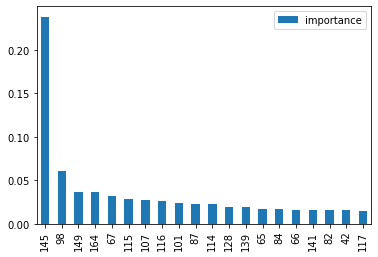

In [18]:
print('=======Only Rdkit Finger Print========')
plt.figure()
fti_df[:20].plot.bar() #Top20

=======Only Calculation Results========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

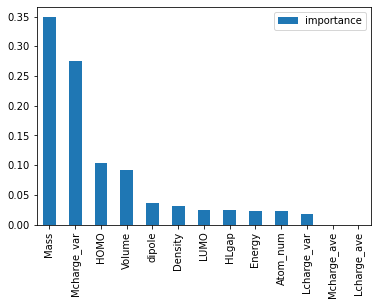

In [19]:
print('=======Only Calculation Results========')
plt.figure()
fti2_df[:20].plot.bar() #Top20

=======Calculation Results + Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

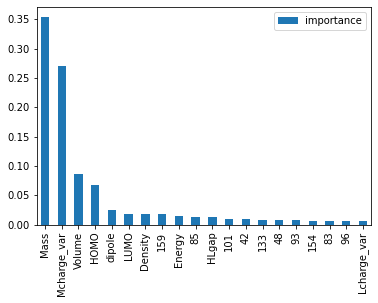

In [20]:
print('=======Calculation Results + Rdkit Finger Print========')
plt.figure()
fti3_df[:20].plot.bar() #Top20

=======Only Rescaled Calculation Results========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

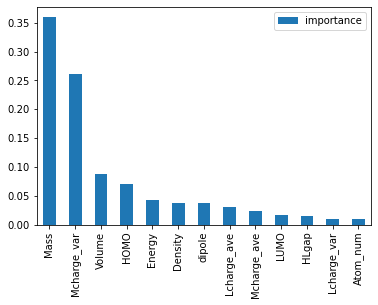

In [21]:
print('=======Only Rescaled Calculation Results========')
plt.figure()
fti4_df[:20].plot.bar() #Top20

=======Rescaled Calculation Results + Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

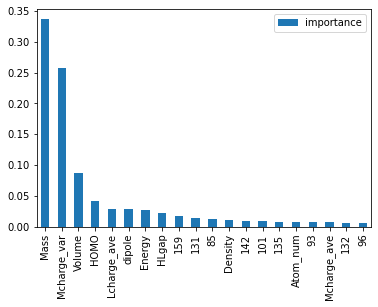

In [22]:
print('=======Rescaled Calculation Results + Rdkit Finger Print========')
plt.figure()
fti5_df[:20].plot.bar() #Top20

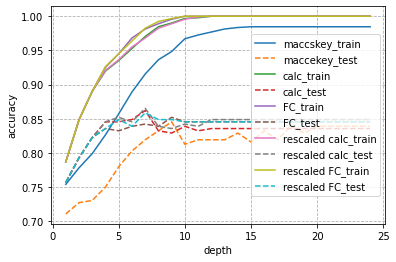

In [23]:
## 決定木の調整
accs_train = []
accs_test = []
accs_calc_train = []
accs_calc_test = []
accs_FC_train = []
accs_FC_test = []
accs_rcalc_train = []
accs_rcalc_test = []
accs_rFC_train = []
accs_rFC_test = []
deep = 25
depth = range(1,deep)
for i in depth:
    tree2 = DecisionTreeClassifier(max_depth=i, random_state=0)
    tree2.fit(x_train, y_train)
    acc_train = tree2.score(x_train, y_train)
    acc_test = tree2.score(x_test, y_test)
    accs_train.append(acc_train)
    accs_test.append(acc_test)
for j in depth:
    calc_tree2 = DecisionTreeClassifier(max_depth=j, random_state=0)
    calc_tree2.fit(xcalc_train, ycalc_train)
    acc_calc_train = calc_tree2.score(xcalc_train, ycalc_train)
    acc_calc_test = calc_tree2.score(xcalc_test, ycalc_test)
    accs_calc_train.append(acc_calc_train)
    accs_calc_test.append(acc_calc_test)
for k in depth:
    FC_tree2 = DecisionTreeClassifier(max_depth=k, random_state=0)
    FC_tree2.fit(xFC_train, yFC_train)
    acc_FC_train = FC_tree2.score(xFC_train, yFC_train)
    acc_FC_test = FC_tree2.score(xFC_test, yFC_test)
    accs_FC_train.append(acc_FC_train)
    accs_FC_test.append(acc_FC_test)
for l in depth:
    rcalc_tree2 = DecisionTreeClassifier(max_depth=l, random_state=0)
    rcalc_tree2.fit(xrcalc_train, yrcalc_train)
    acc_rcalc_train = rcalc_tree2.score(xrcalc_train, yrcalc_train)
    acc_rcalc_test = rcalc_tree2.score(xrcalc_test, yrcalc_test)
    accs_rcalc_train.append(acc_rcalc_train)
    accs_rcalc_test.append(acc_rcalc_test)
for m in depth:
    rFC_tree2 = DecisionTreeClassifier(max_depth=m, random_state=0)
    rFC_tree2.fit(xrFC_train, yrFC_train)
    acc_rFC_train = rFC_tree2.score(xrFC_train, yrFC_train)
    acc_rFC_test = rFC_tree2.score(xrFC_test, yrFC_test)
    accs_rFC_train.append(acc_rFC_train)
    accs_rFC_test.append(acc_rFC_test)
    
#graph
plt.plot(depth, accs_train, label = 'maccskey_train', linestyle="solid")
plt.plot(depth, accs_test, label = 'maccekey_test', linestyle="dashed")

plt.plot(depth, accs_calc_train, label = 'calc_train', linestyle="solid")
plt.plot(depth, accs_calc_test, label = 'calc_test', linestyle="dashed")

plt.plot(depth, accs_FC_train, label = 'FC_train', linestyle="solid")
plt.plot(depth, accs_FC_test, label = 'FC_test', linestyle="dashed")

plt.plot(depth, accs_rcalc_train, label = 'rescaled calc_train', linestyle="solid")
plt.plot(depth, accs_rcalc_test, label = 'rescaled calc_test', linestyle="dashed")

plt.plot(depth, accs_rFC_train, label = 'rescaled FC_train', linestyle="solid")
plt.plot(depth, accs_rFC_test, label = 'rescaled FC_test', linestyle="dashed")



# 凡例を表示
plt.legend(loc=5)
# グリッド
plt.grid(linestyle='--')
#軸ラベル
plt.xlabel('depth')
plt.ylabel('accuracy')

plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


=======Only Rdkit Finger Print========


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


=======Only Calculation Results========


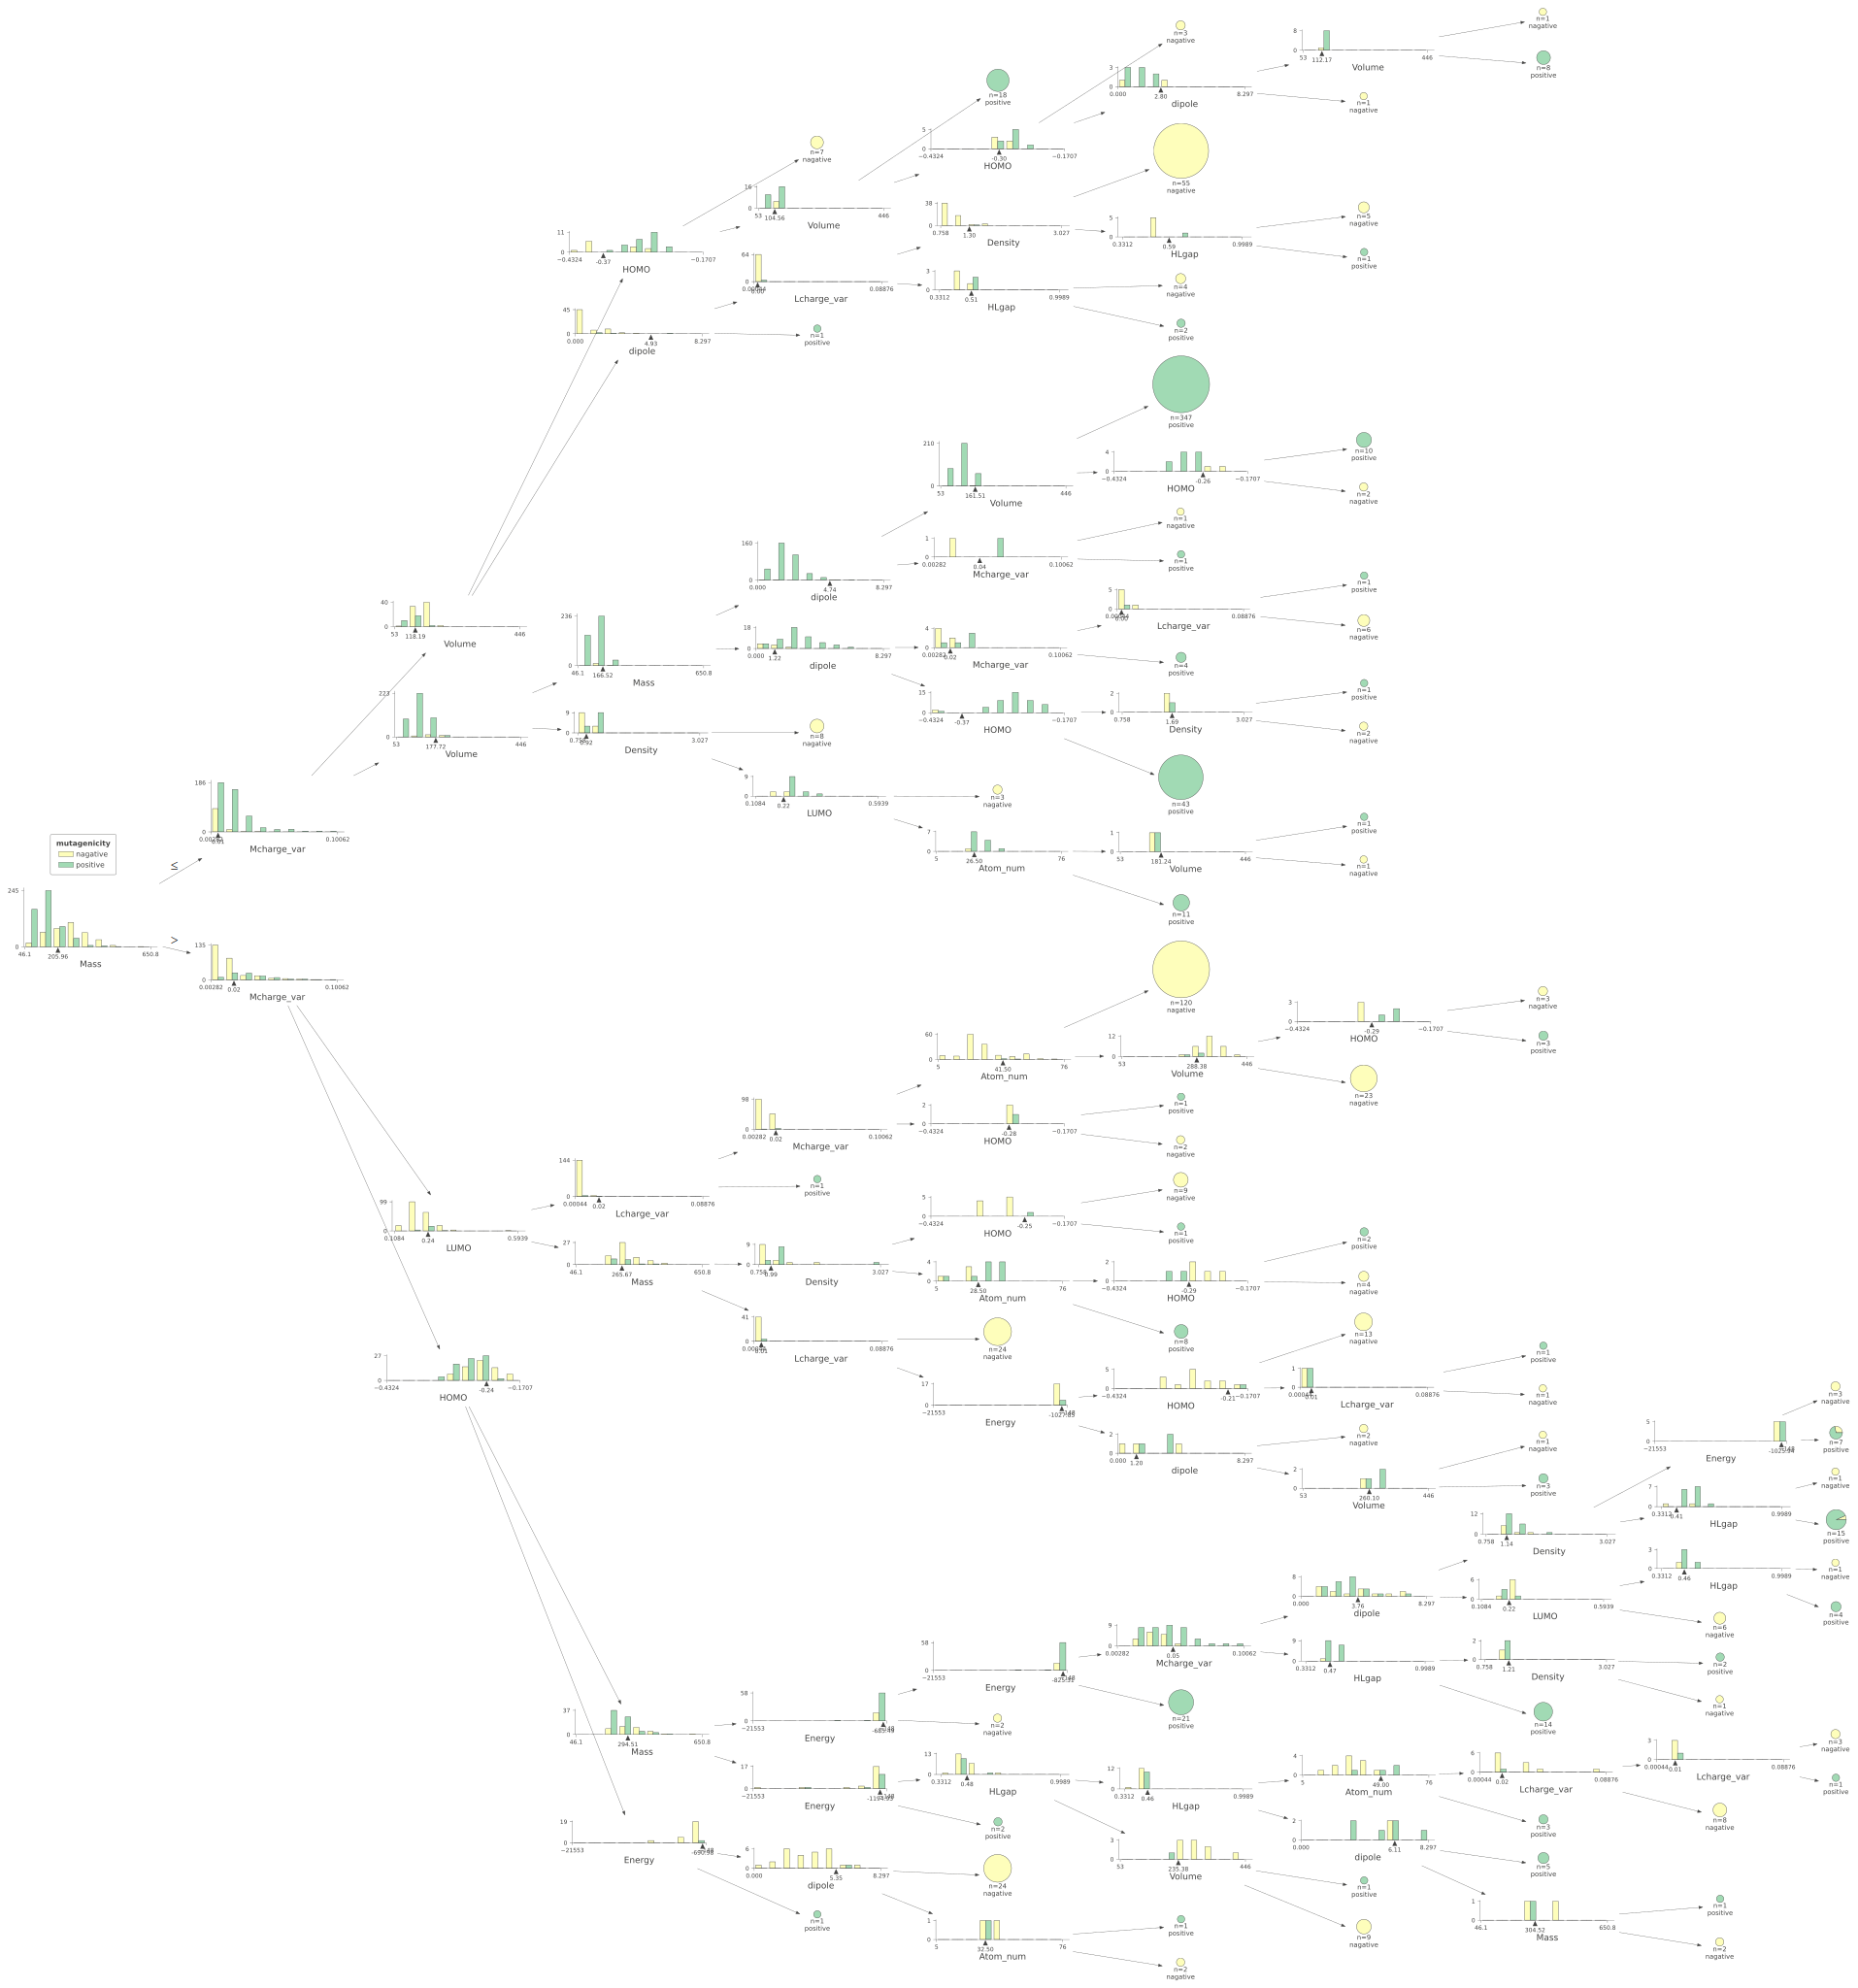

=======Calculation Results + Rdkit Finger Print========


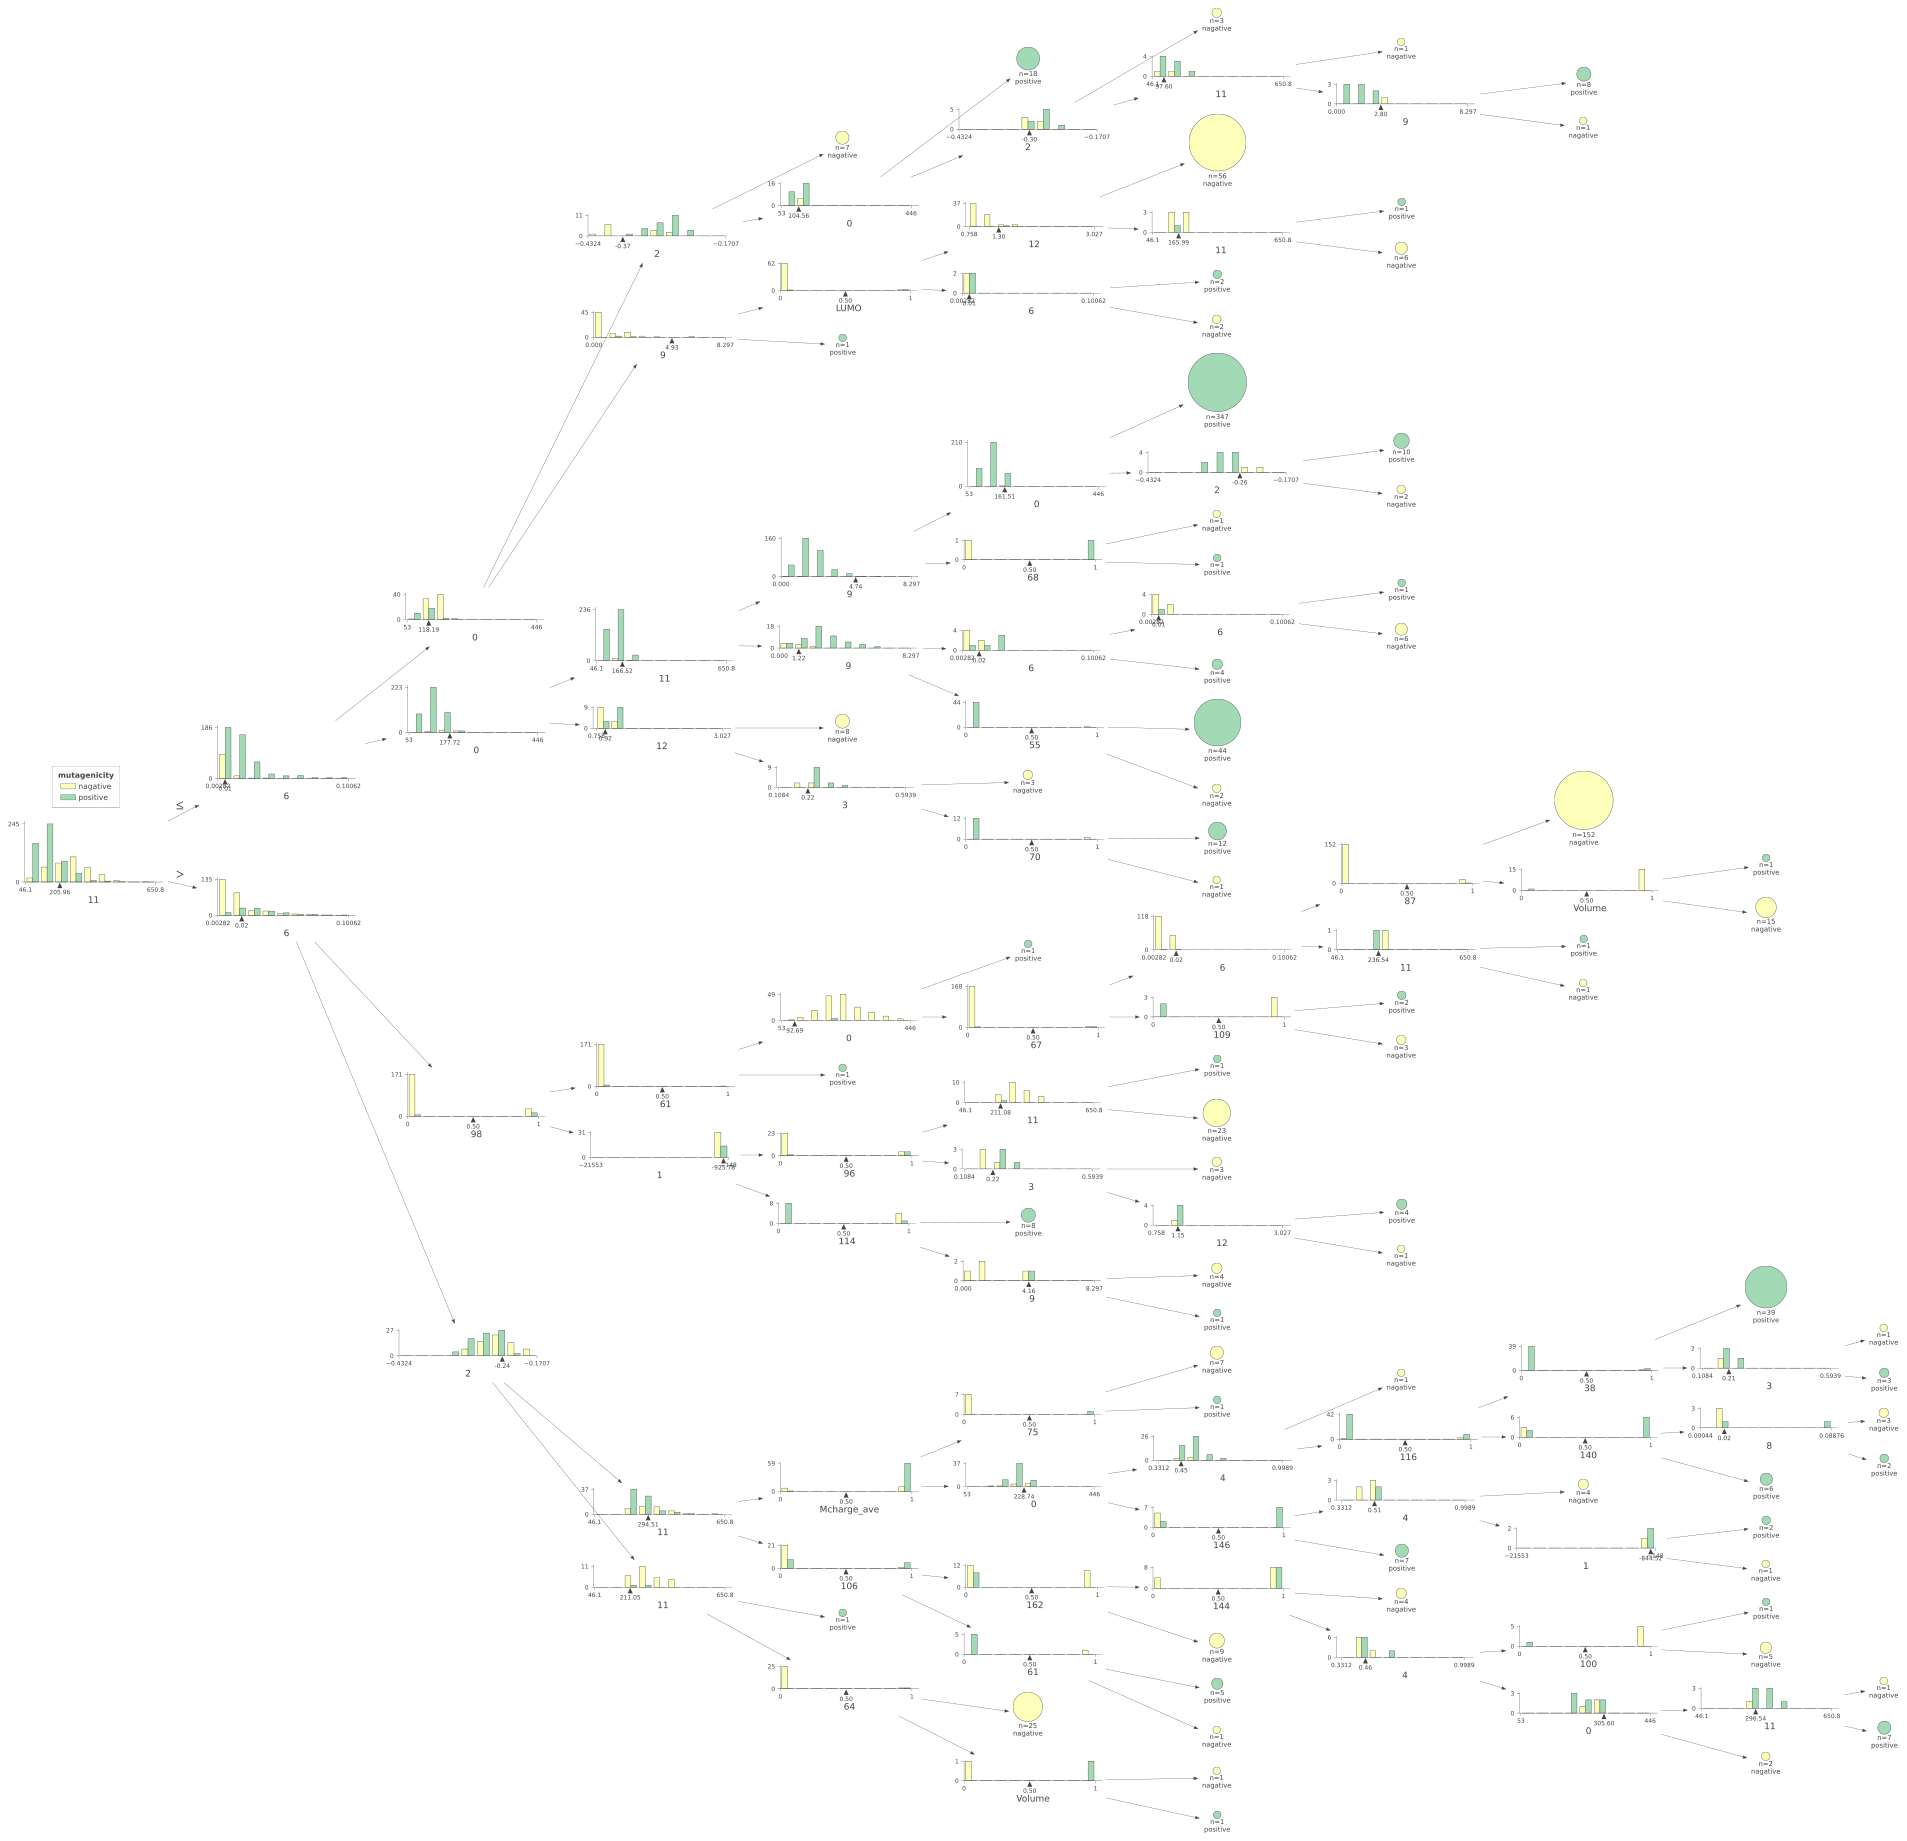

=======Only Rescaled Calculation Results========


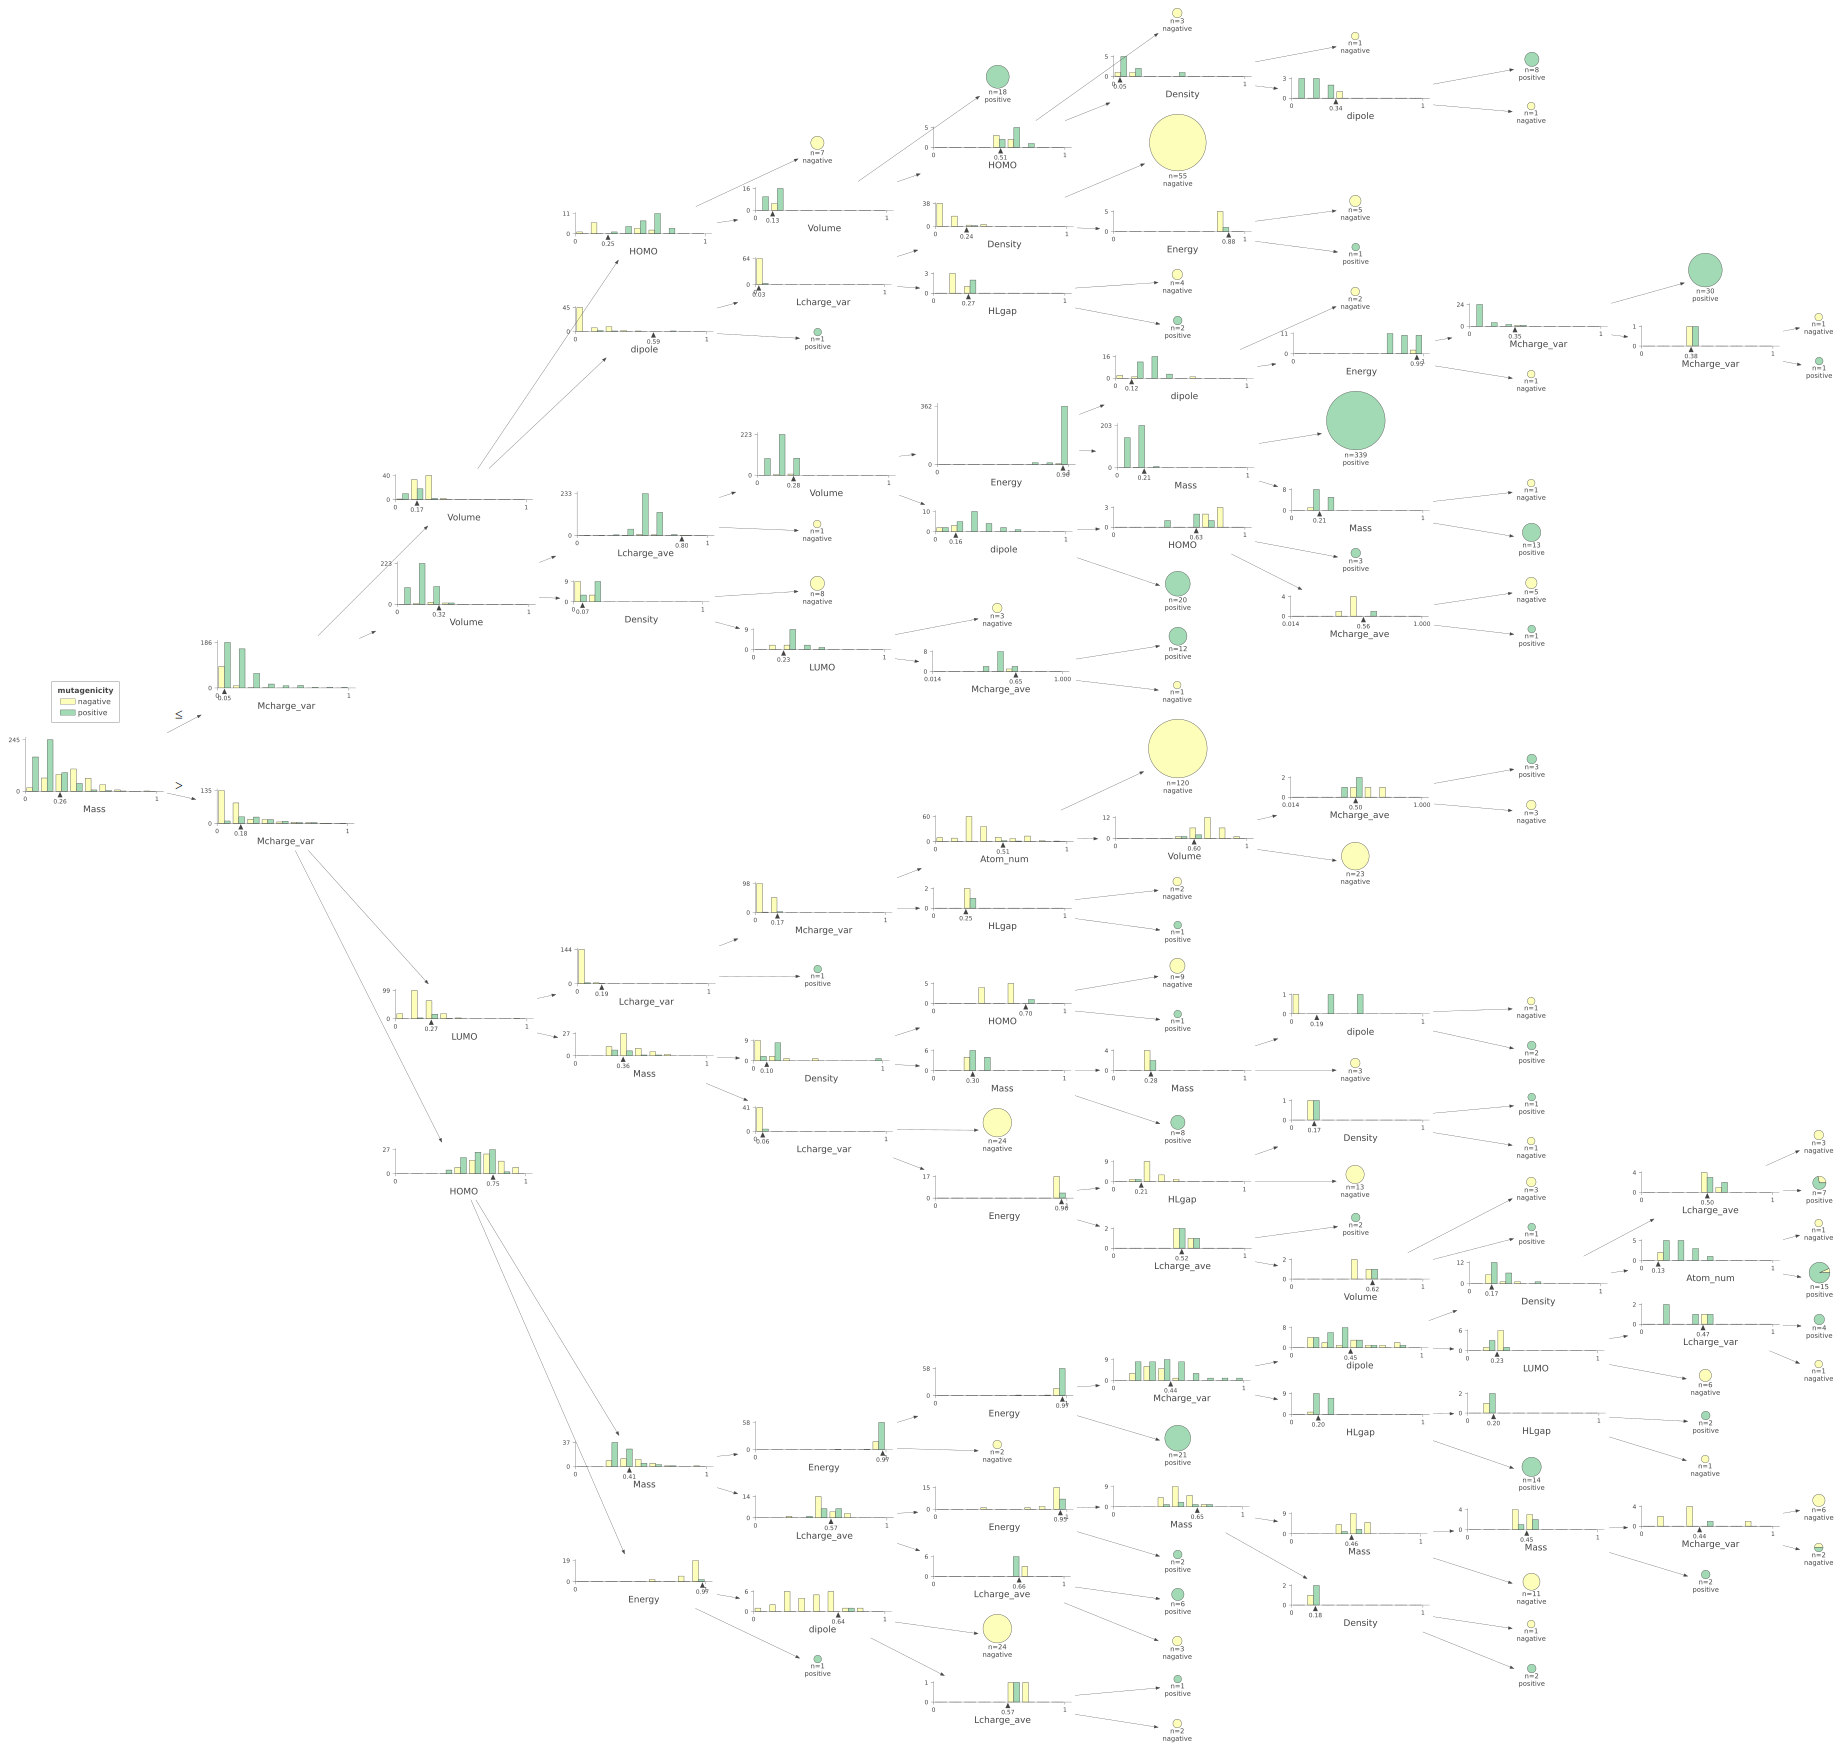

=======Rescaled Calculation Results + Rdkit Finger Print========


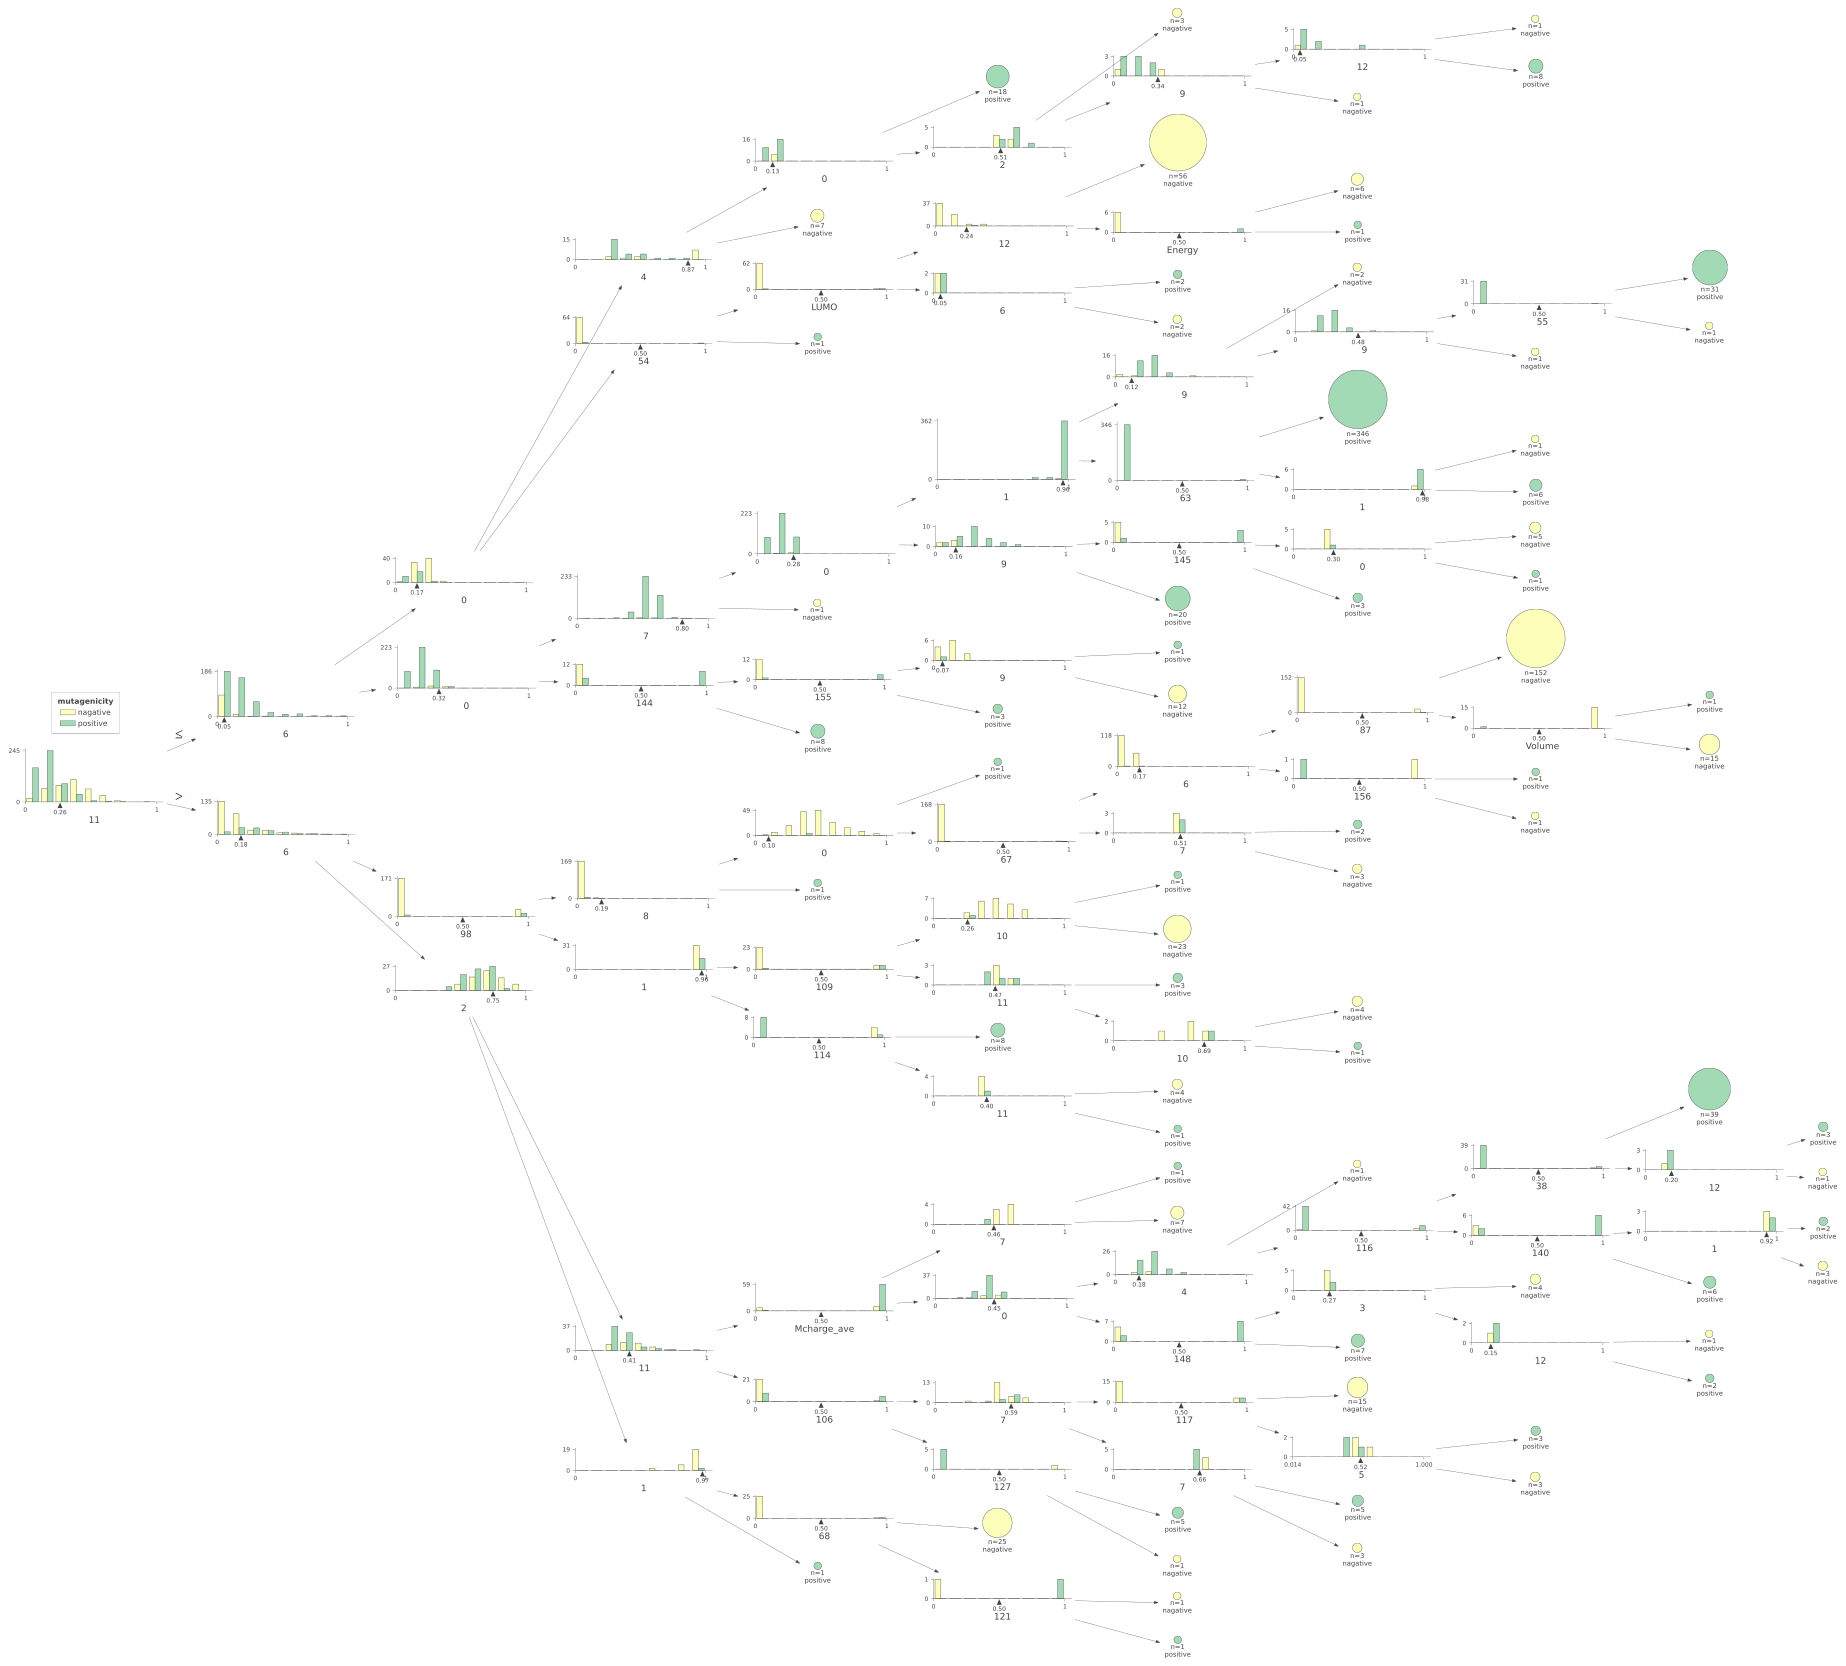

In [14]:
from dtreeviz.trees import dtreeviz
import numpy as np
maccskey_name = list(range(len(maccskeys[0])))
FC_name = maccskey_name + mol_props

print('=======Only Rdkit Finger Print========')
tree_maccskey = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_maccskey.fit(x_train, y_train)
viz_pre_maccs = dtreeviz(tree_maccskey, np.array(x_train), np.array(y_train), target_name= 'mutagenicity', feature_names=maccskey_name, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre_maccs)

print('=======Only Calculation Results========')
tree_calc = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_calc.fit(xcalc_train, ycalc_train)
viz_pre_calc  = dtreeviz(tree_calc, np.array(xcalc_train), np.array(ycalc_train), target_name= 'mutagenicity', feature_names=mol_props, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre_calc)

print('=======Calculation Results + Rdkit Finger Print========')
tree_FC = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_FC.fit(xFC_train, yFC_train)
viz_pre_FC = dtreeviz(tree_FC, np.array(xFC_train), np.array(yFC_train), target_name= 'mutagenicity', feature_names=FC_name, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre_FC)

print('=======Only Rescaled Calculation Results========')
tree_rcalc = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_rcalc.fit(xrcalc_train, yrcalc_train)
viz_pre_rcalc  = dtreeviz(tree_rcalc, np.array(xrcalc_train), np.array(yrcalc_train), target_name= 'mutagenicity', feature_names=mol_props, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre_rcalc)

print('=======Rescaled Calculation Results + Rdkit Finger Print========')
tree_rFC = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_rFC.fit(xrFC_train, yrFC_train)
viz_pre_rFC = dtreeviz(tree_rFC, np.array(xrFC_train), np.array(yrFC_train), target_name= 'mutagenicity', feature_names=FC_name, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre_rFC)